### Import data

In [52]:
include("importData.jl")
include("DDEmodel.jl")
# include("Hill.jl")
include("plot.jl")

# import drug concentrations
param_lap_dde = CSV.read(".//figures//Lapatinib//params_lap_DDE.csv")
concentrations = permutedims(Vector(param_lap_dde[8,2:end]));
print(concentrations)

# import G1 and G2 data
pop, g2, g1, g1_0, g2_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv");

Any[0.0 5.0 10.0 25.0 50.0 100.0 250.0 500.0]

### Hill mode, residual functions and optimization

In [53]:
# hillParams should be something like [EC50, alpha_min, alpha_max, alpha_b, EC50, beta_min, beta_max, beta_b...]
hill(p, concentration) =  p[2] + ((p[3] - p[2]) / (1 + 10^((concentration - p[1])*p[4])))

function residHill(hillParams, concentrations, g1, g2)
    """ This functions takes in hill parameters for all the concentrations and calculates
    DDE parameters, passes them to residual function and based off of these, optimizes the model
    and estimates hill parameters. """

    num_concentration = length(concentrations)
    data_size = length(g1[:, 1])
    total_res = zeros(2, data_size*num_concentration)

#     EC50  for all of the trials is hillParams[1]
    for ii in 1:num_concentration
        alpha = hill(append!([hillParams[1]], hillParams[2:4]), concentrations[ii])
        beta = hill(append!([hillParams[1]], hillParams[5:7]), concentrations[ii])
        tau1 = hill(append!([hillParams[1]], hillParams[8:10]), concentrations[ii])
        tau2 = hill(append!([hillParams[1]], hillParams[11:13]), concentrations[ii])
        gamma1 = hill(append!([hillParams[1]], hillParams[14:16]), concentrations[ii])
        gamma2 = hill(append!([hillParams[1]], hillParams[17:19]), concentrations[ii])

        pp = [alpha, beta, tau1, tau2, gamma1, gamma2]
        residuals = resid(pp, ii, g1, g2)
        total_res[1, ((ii-1)*data_size +1):(ii*data_size)] = residuals[1, :]
        total_res[2, ((ii-1)*data_size +1):(ii*data_size)] = residuals[2, :]
    end 
    return total_res
end


function optimize_hill(concentrations, guess, low, high)
    residue(hillParams) =residHill(hillParams, concentrations, g1, g2)
    results_hill = optimize(residue, guess, LevenbergMarquardt(), lower = low, upper = high)
    return results_hill
end

optimize_hill (generic function with 1 method)

In [54]:
low = 0.0001*zeros(18)
low = append!([50.0], low)
high_temp = [2.50, 2.50, 2.50]
high = repeat(high_temp, 6)
high = append!([300.0], high)

guess = [100.0, 0.1, 1.1, 0.01, 0.1, 1.0, 0.01, 1.1, 0.1, 0.01, 1.1, 0.1, 0.01, 1.1, 0.1, 0.01, 1.1, 0.1, 0.01]
optimizer_result = optimize_hill(concentrations, guess, low, high)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [50.09350622655504,0.3055675723948301,1.6018450780141915,0.011956489806304278,0.18873577863614335,1.0960431116064553,2.790731729249831e-5,1.7676250888395622,1.0209093529870852,0.02350041346267592,0.9704340794514481,0.17084130161852462,0.004183284491462039,0.0,0.0,0.0,0.6639447474054945,0.5777268425245713,0.0022016834657388167]
 * Sum of squares at Minimum: 22826.931943
 * Iterations: 127
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 128
 * Gradient Calls: 94
 * Multiplication Calls: 381


### Plot Hill curve for alpha (first parameter)

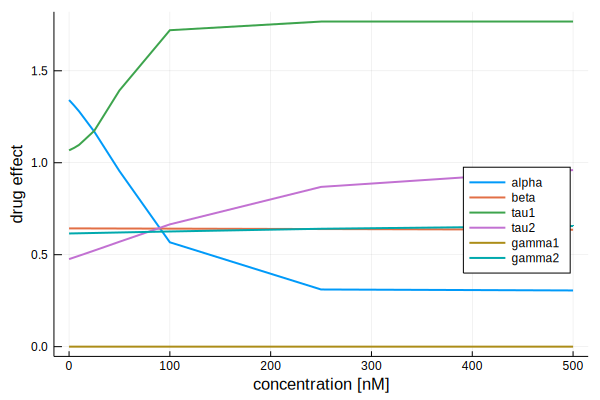

In [55]:
using Plots;
params = optimizer_result.minimizer
effects = zeros(6, 8)
for i in 1:8
    effects[1, i] = hill(params[1:4], concentrations[i])
    effects[2, i] = hill(append!([params[1]], params[5:7]), concentrations[i])
    effects[3, i] = hill(append!([params[1]], params[8:10]), concentrations[i])
    effects[4, i] = hill(append!([params[1]], params[11:13]), concentrations[i])
    effects[5, i] = hill(append!([params[1]], params[14:16]), concentrations[i])
    effects[6, i] = hill(append!([params[1]], params[17:19]), concentrations[i])
end


c = permutedims(Array(concentrations))
plot(c, effects[1, :], label = "alpha", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(c, effects[2, :], label = "beta", linewidth = 2, legend =:right)
plot!(c, effects[3, :], label = "tau1", linewidth = 2)
plot!(c, effects[4, :], label = "tau2", linewidth = 2)
plot!(c, effects[5, :], label = "gamma1", linewidth = 2)
plot!(c, effects[6, :], label = "gamma2", linewidth = 2)


### Plot the data with the new set of parameters for DDE

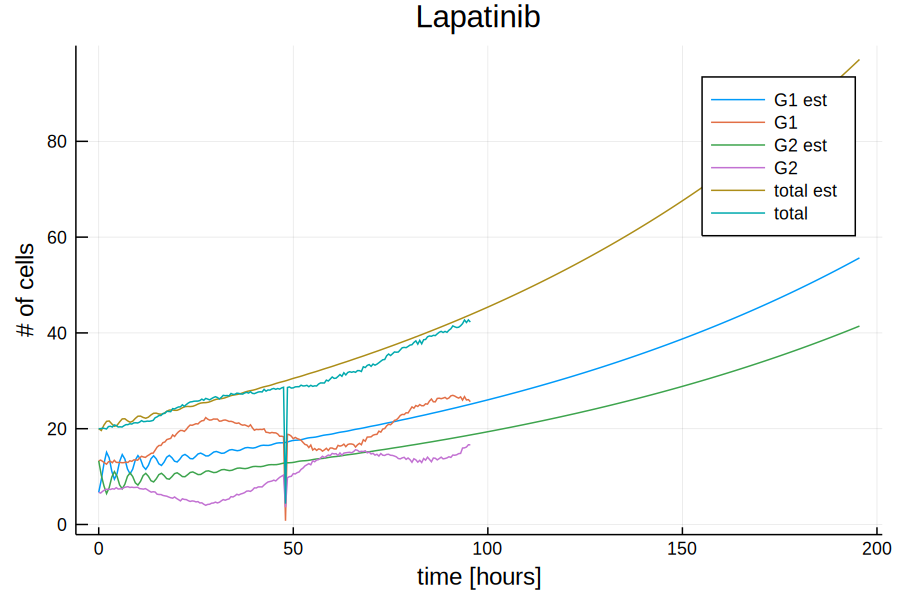

In [56]:
j = 5
# for instance we want to plot the data and estimated for trial 8
alpha_ = hill(params[1:4], concentrations[j])
beta_ = hill(append!([params[1]], params[5:7]), concentrations[j])
tau1_ = hill(append!([params[1]], params[8:10]), concentrations[j])
tau2_ =hill(append!([params[1]], params[11:13]), concentrations[j])
gamma1_ = hill(append!([params[1]], params[14:16]), concentrations[j])
gamma2_ = hill(append!([params[1]], params[17:19]), concentrations[j])

control = [alpha_, beta_, tau1_, tau2_, gamma1_, gamma2_]
plotIt(control, g1, g2, g1_0, g2_0, pop, j, "Lapatinib")
# print(control)